In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 16, 10

#pd.set_option('display.max_rows', None) # don't limit the number of rows in printouts of dataframes
#pd.set_option('display.max_seq_items', None)
#pd.set_option('display.large_repr', 'truncate')


# Read in data and do basic massaging

In [2]:
df_us_raw = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
df_us_raw.head(2)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,77,82,84,93,112,113,121,121,128,130


In [3]:
df_us_raw.groupby(['Country_Region']).sum().loc[:,'4/4/20']

Country_Region
US    308848
Name: 4/4/20, dtype: int64

In [4]:
df_global_raw = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_global_raw.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,237,273,281,299,349,367,423,444,484,521
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,259,277,304,333,361,377,383,400,409,416


In [5]:
df_global_raw.groupby(['Country/Region']).sum().loc['US',:]

Lat            37.0902
Long          -95.7129
1/22/20         1.0000
1/23/20         1.0000
1/24/20         2.0000
              ...     
4/6/20     366667.0000
4/7/20     396223.0000
4/8/20     429052.0000
4/9/20     461437.0000
4/10/20    496535.0000
Name: US, Length: 82, dtype: float64

In [6]:
# change the value of 'US' to 'United States' so that
# it is different from the df_us_raw file so we don't
# double count
df_global_raw = df_global_raw.set_index('Country/Region')
as_list = df_global_raw.index.tolist()
idx = as_list.index('US')
as_list[idx] = 'United States'
df_global_raw.index = as_list
print(df_global_raw.loc['United States'])
df_global_raw = df_global_raw.reset_index()
df_global_raw.rename(columns={'index': 'Country/Region'}, inplace=True)

Province/State        NaN
Lat               37.0902
Long             -95.7129
1/22/20                 1
1/23/20                 1
                   ...   
4/6/20             366667
4/7/20             396223
4/8/20             429052
4/9/20             461437
4/10/20            496535
Name: United States, Length: 83, dtype: object


In [7]:

print(df_us_raw.columns)
print(df_global_raw.columns)

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20',
       '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20',
       '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20',
       '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20',
       '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20',
       '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20',
       '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20',
       '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20',
       '3/15/20', '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20',
       '3/21/20', '3/22/20', '3/23/20', '3/24/20', '3/25/20', '3/26/20',
       '3/27/20', '3/28/20', '3/29/20', '3/30/20', '3/31/20', '4/1/20',
       '4/2/20', '4/3/20', '4

In [8]:
df_us_raw.Combined_Key.unique()

array(['American Samoa, US', 'Guam, US', 'Northern Mariana Islands, US',
       ..., 'Unassigned, Wisconsin, US', 'Unassigned, Wyoming, US',
       'Grand Princess, US'], dtype=object)

In [9]:
df_global_raw = df_global_raw.rename(columns={'Province/State': 'Province_State', 
                                             'Country/Region': 'Country_Region',
                                             'Long': 'Long_'})
#df_global_raw['Combined_Key'] = df_global_raw.Province_State.astype(str).str.cat(df_global_raw.Country_Region.astype(str), sep=', ', na_rep='')
df_global_raw.insert(loc=4, column='Combined_Key', value=df_global_raw.Province_State.astype(str).str.cat(df_global_raw.Country_Region.astype(str), sep=', ', na_rep=''))


df_raw = df_global_raw.append(df_us_raw)
df_raw

,Country_Region,Province_State,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,...,4/7/20,4/8/20,4/9/20,4/10/20,UID,iso2,iso3,code3,FIPS,Admin2
0,Afghanistan,NaN,33.0000,65.0000,"nan, Afghanistan",0,0,0,0,0,...,423,444,484,521,NaN,NaN,NaN,NaN,NaN,NaN
1,Albania,NaN,41.1533,20.1683,"nan, Albania",0,0,0,0,0,...,383,400,409,416,NaN,NaN,NaN,NaN,NaN,NaN
2,Algeria,NaN,28.0339,1.6596,"nan, Algeria",0,0,0,0,0,...,1468,1572,1666,1761,NaN,NaN,NaN,NaN,NaN,NaN
3,Andorra,NaN,42.5063,1.5218,"nan, Andorra",0,0,0,0,0,...,545,564,583,601,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,NaN,-11.2027,17.8739,"nan, Angola",0,0,0,0,0,...,17,19,19,19,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3248,US,Washington,0.0000,0.0000,"Unassigned, Washington, US",0,0,0,0,0,...,677,915,838,908,84090053.0,US,USA,840.0,90053.0,Unassigned
3249,US,West Virginia,0.0000,0.0000,"Unassigned, West Virginia, US",0,0,0,0,0,...,0,21,0,0,84090054.0,US,USA,840.0,90054.0,Unassigned
3250,US,Wisconsin,0.0000,0.0000,"Unassigned, Wisconsin, US",0,0,0,0,0,...,0,0,0,0,84090055.0,US,USA,840.0,90055.0,Unassigned
3251,US,Wyoming,0.0000,0.0000,"Unassigned, Wyoming, US",0,0,0,0,0,...,0,0,0,0,84090056.0,US,USA,840.0,90056.0,Unassigned


In [10]:
df_global_raw.Combined_Key.unique()

array(['nan, Afghanistan', 'nan, Albania', 'nan, Algeria', 'nan, Andorra',
       'nan, Angola', 'nan, Antigua and Barbuda', 'nan, Argentina',
       'nan, Armenia', 'Australian Capital Territory, Australia',
       'New South Wales, Australia', 'Northern Territory, Australia',
       'Queensland, Australia', 'South Australia, Australia',
       'Tasmania, Australia', 'Victoria, Australia',
       'Western Australia, Australia', 'nan, Austria', 'nan, Azerbaijan',
       'nan, Bahamas', 'nan, Bahrain', 'nan, Bangladesh', 'nan, Barbados',
       'nan, Belarus', 'nan, Belgium', 'nan, Benin', 'nan, Bhutan',
       'nan, Bolivia', 'nan, Bosnia and Herzegovina', 'nan, Brazil',
       'nan, Brunei', 'nan, Bulgaria', 'nan, Burkina Faso',
       'nan, Cabo Verde', 'nan, Cambodia', 'nan, Cameroon',
       'Alberta, Canada', 'British Columbia, Canada',
       'Grand Princess, Canada', 'Manitoba, Canada',
       'New Brunswick, Canada', 'Newfoundland and Labrador, Canada',
       'Nova Scotia, Can

In [11]:
df_raw.Country_Region.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Diamond Princess', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala',
       'Guinea', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary',
       'Iceland', 'India

In [12]:
df_raw = df_raw.drop(labels=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2'], axis=1)

In [13]:
df_raw.columns

Index(['Country_Region', 'Province_State', 'Lat', 'Long_', 'Combined_Key',
       '1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20',
       '2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20', '2/9/20',
       '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20', '2/15/20',
       '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20', '2/21/20',
       '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20', '2/27/20',
       '2/28/20', '2/29/20', '3/1/20', '3/2/20', '3/3/20', '3/4/20', '3/5/20',
       '3/6/20', '3/7/20', '3/8/20', '3/9/20', '3/10/20', '3/11/20', '3/12/20',
       '3/13/20', '3/14/20', '3/15/20', '3/16/20', '3/17/20', '3/18/20',
       '3/19/20', '3/20/20', '3/21/20', '3/22/20', '3/23/20', '3/24/20',
       '3/25/20', '3/26/20', '3/27/20', '3/28/20', '3/29/20', '3/30/20',
       '3/31/20', '4/1/20', '4/2/20', '4/3/20', '4/4/20', '4/5/20', '4/6/20',
       '4/7/20', '4/8/20', '4

In [14]:
#df_raw['Country_Region'].unique()

In [15]:
#df_raw['Province_State'].unique()

In [16]:
df1 = df_raw.melt(id_vars=df_raw.columns[:5], var_name='Date', value_name='Confirmed')
df1 = df1.set_index('Date')
df1

,Country_Region,Province_State,Lat,Long_,Combined_Key,Confirmed
Date,,,,,,
1/22/20,Afghanistan,NaN,33.0000,65.0000,"nan, Afghanistan",0
1/22/20,Albania,NaN,41.1533,20.1683,"nan, Albania",0
1/22/20,Algeria,NaN,28.0339,1.6596,"nan, Algeria",0
1/22/20,Andorra,NaN,42.5063,1.5218,"nan, Andorra",0
1/22/20,Angola,NaN,-11.2027,17.8739,"nan, Angola",0
...,...,...,...,...,...,...
4/10/20,US,Washington,0.0000,0.0000,"Unassigned, Washington, US",908
4/10/20,US,West Virginia,0.0000,0.0000,"Unassigned, West Virginia, US",0
4/10/20,US,Wisconsin,0.0000,0.0000,"Unassigned, Wisconsin, US",0


In [17]:
df2 = df_raw.melt(id_vars='Combined_Key', value_vars=df_raw.columns[5:], var_name='Date', value_name='Confirmed')
df2['Date'] = pd.to_datetime(df2.Date)
df2 = df2.set_index('Date')
df2

,Combined_Key,Confirmed
Date,,
2020-01-22,"nan, Afghanistan",0
2020-01-22,"nan, Albania",0
2020-01-22,"nan, Algeria",0
2020-01-22,"nan, Andorra",0
2020-01-22,"nan, Angola",0
...,...,...
2020-04-10,"Unassigned, Washington, US",908
2020-04-10,"Unassigned, West Virginia, US",0
2020-04-10,"Unassigned, Wisconsin, US",0


# Narrow down to a set of interesting States and Counties and graph

In [18]:
# just a cell to try different approaches for choosing rows
rowsofinterest = df2['Combined_Key'].isin(['Santa Clara, California, US', 'New York City, New York, US', 'Salt Lake, Utah, US'])
rowsofinterest = df2['Combined_Key'].str.endswith('California, US')
df2.loc[rowsofinterest,:].head(2)

,Combined_Key,Confirmed
Date,,
2020-01-22,"Alameda, California, US",0
2020-01-22,"Alpine, California, US",0


In [19]:
df = pd.DataFrame(index = df2.index.unique(),
                     data = {
                         'California': df2.loc[df2['Combined_Key'].str.endswith('California, US'),'Confirmed'].groupby(level=0).sum(),
                         'New York': df2.loc[df2['Combined_Key'].str.endswith('New York, US'),'Confirmed'].groupby(level=0).sum(),
                         'Washington': df2.loc[df2['Combined_Key'].str.endswith('Washington, US'),'Confirmed'].groupby(level=0).sum(),
                         'Utah': df2.loc[df2['Combined_Key'].str.endswith('Utah, US'),'Confirmed'].groupby(level=0).sum(),
                         'Hawaii': df2.loc[df2['Combined_Key'].str.endswith('Hawaii, US'),'Confirmed'].groupby(level=0).sum(),
                         'Idaho': df2.loc[df2['Combined_Key'].str.endswith('Idaho, US'),'Confirmed'].groupby(level=0).sum(),
                         'Texas': df2.loc[df2['Combined_Key'].str.endswith('Texas, US'),'Confirmed'].groupby(level=0).sum(),
                         'Santa Clara Co.': df2.loc[df2['Combined_Key']=='Santa Clara, California, US', 'Confirmed'].groupby(level=0).sum(),
                         #'Los Angeles Co.': df2.loc[df2['Combined_Key']=='Los Angeles, California, US', 'Confirmed'].groupby(level=0).sum(),
                         'Japan': df2.loc[df2['Combined_Key'].str.endswith('Japan'),'Confirmed'].groupby(level=0).sum(),
                         # note that in the following, we are using 'United States' which is the renamed country
                         # value from the global file so that we don't double count
                         'United States': df2.loc[df2['Combined_Key'].str.endswith('United States'),'Confirmed'].groupby(level=0).sum(),
                         'Singapore': df2.loc[df2['Combined_Key'].str.endswith('Singapore'),'Confirmed'].groupby(level=0).sum(),
                         'Italy': df2.loc[df2['Combined_Key'].str.endswith('Italy'),'Confirmed'].groupby(level=0).sum(),
                         'Spain': df2.loc[df2['Combined_Key'].str.endswith('Spain'),'Confirmed'].groupby(level=0).sum(),
                         'Iran': df2.loc[df2['Combined_Key'].str.endswith('Iran'),'Confirmed'].groupby(level=0).sum(),
                         'France': df2.loc[df2['Combined_Key'].str.endswith('France'),'Confirmed'].groupby(level=0).sum(),
                         'Germany': df2.loc[df2['Combined_Key'].str.endswith('Germany'),'Confirmed'].groupby(level=0).sum(),
                         'Switzerland': df2.loc[df2['Combined_Key'].str.endswith('Switzerland'),'Confirmed'].groupby(level=0).sum(),
                         'United Kingdom': df2.loc[df2['Combined_Key'].str.endswith('United Kingdom'),'Confirmed'].groupby(level=0).sum(),
                         'South Korea': df2.loc[df2['Combined_Key'].str.endswith('Korea, South'),'Confirmed'].groupby(level=0).sum(),
                         'Taiwan': df2.loc[df2['Combined_Key'].str.endswith('Taiwan*'),'Confirmed'].groupby(level=0).sum(),
                         'Philippines': df2.loc[df2['Combined_Key'].str.endswith('Philippines'),'Confirmed'].groupby(level=0).sum(),
                         'Ireland': df2.loc[df2['Combined_Key'].str.endswith('Ireland'),'Confirmed'].groupby(level=0).sum(),
                         'China': df2.loc[df2['Combined_Key'].str.endswith('China'),'Confirmed'].groupby(level=0).sum(),
                     }

)
df = df.loc[~(df==0).all(axis=1)] # drop rows with all zeros
# The next two drops ensure that if the two source files are out of sync, we don't
# show the rows where there is zero data for one of them
df = df.loc[~(df['Italy']==0)] # drop rows if Italy is Zero (from global source)
df = df.loc[~(df['California']==0)] # drop rows if California is Zero (from US source)
df = df.loc['2/1/20':,:]
df

,California,New York,Washington,Utah,Hawaii,Idaho,Texas,Santa Clara Co.,Japan,United States,...,Iran,France,Germany,Switzerland,United Kingdom,South Korea,Taiwan,Philippines,Ireland,China
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-01,3,0,1,0,0,0,0,1,20,8,...,0,6,8,0,2,12,10,1,0,11891
2020-02-02,3,0,1,0,0,0,0,1,20,8,...,0,6,10,0,2,15,10,2,0,16630
2020-02-03,6,0,1,0,0,0,0,2,20,11,...,0,6,12,0,2,15,10,2,0,19716
2020-02-04,6,0,1,0,0,0,0,2,22,11,...,0,6,12,0,2,16,11,2,0,23707
2020-02-05,6,0,1,0,0,0,0,2,22,11,...,0,6,12,0,2,19,11,2,0,27440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-06,16019,131815,8311,1583,387,1101,8043,1207,3654,366667,...,60500,98963,103374,21657,52279,10284,373,3660,5364,82665
2020-04-07,17351,139875,8692,1640,410,1170,8925,1285,3906,396223,...,62589,110065,107663,22253,55949,10331,376,3764,5709,82718
2020-04-08,18897,151061,9276,1747,410,1210,9777,1380,4257,429052,...,64586,113959,113296,23280,61474,10384,379,3870,6074,82809


In [20]:
df['United States']

Date
2020-02-01         8
2020-02-02         8
2020-02-03        11
2020-02-04        11
2020-02-05        11
               ...  
2020-04-06    366667
2020-04-07    396223
2020-04-08    429052
2020-04-09    461437
2020-04-10    496535
Name: United States, Length: 70, dtype: int64

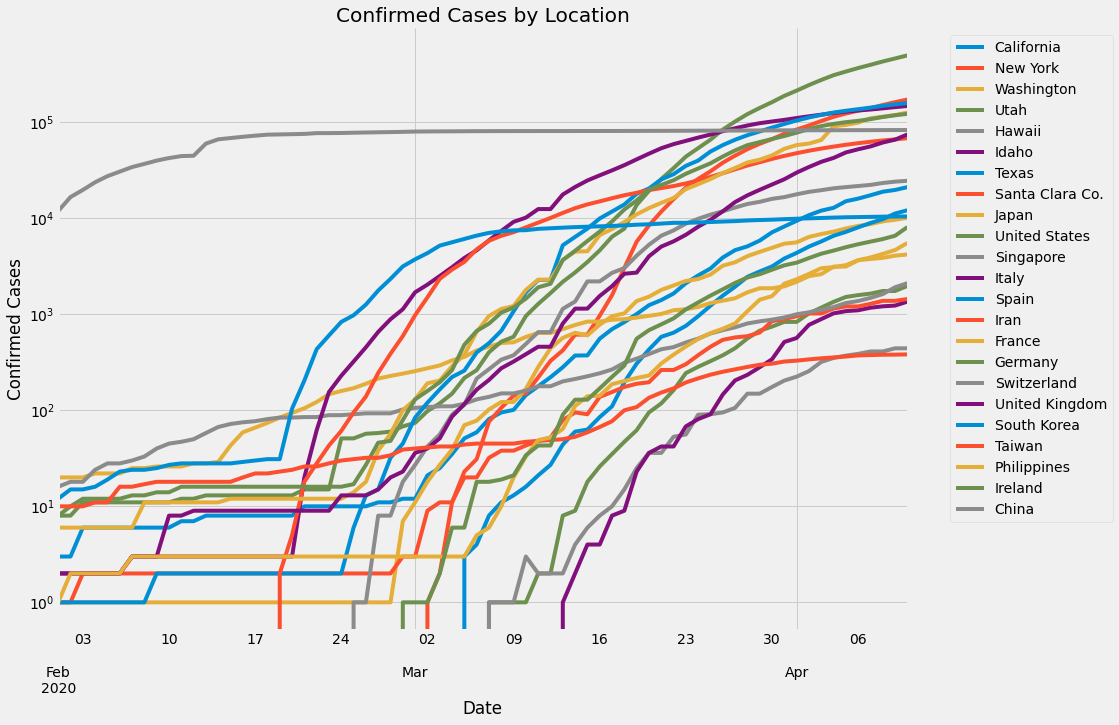

In [21]:
#newdf.loc['2/1/20':,:].plot(logy=True)
df.plot(logy=True)
plt.legend(bbox_to_anchor=(1.25, 1))
plt.tight_layout()
plt.title("Confirmed Cases by Location")
plt.ylabel("Confirmed Cases")
sns.despine()

# TEMP ONLY
Drop rows that have data glitches

In [22]:
#df = df.drop(labels=['3/22/20', '3/30/20'], axis=0)

# Graph raw data

### label_lines routine

In [23]:
def label_lines(df, ax, tuple_selector=None, print_value=False):
    '''Labels lines in a chart assuming that some lines will be different lengths than others
       If tuple_selector is set to an integer, use it as an index to the label'''
    for label, series in df.items():
        prev_x = series.index[0]
        prev_data = series.iloc[0]
        for index, data in series.items():
            if pd.isnull(data):
                break
            prev_x = index
            prev_data = data
        if not (tuple_selector is None):
            if print_value:
                label = '{} ({:,})'.format(label[tuple_selector], int(prev_data))
            else:
                label = label[tuple_selector]
        else:
            if print_value:
                label = '{} ({:,})'.format(label, int(prev_data))
        ax.annotate(label, (prev_x, prev_data),
                            xytext=(10,0), 
                            textcoords='offset pixels',
                            family='sans-serif', fontsize=14, color='darkslategrey')

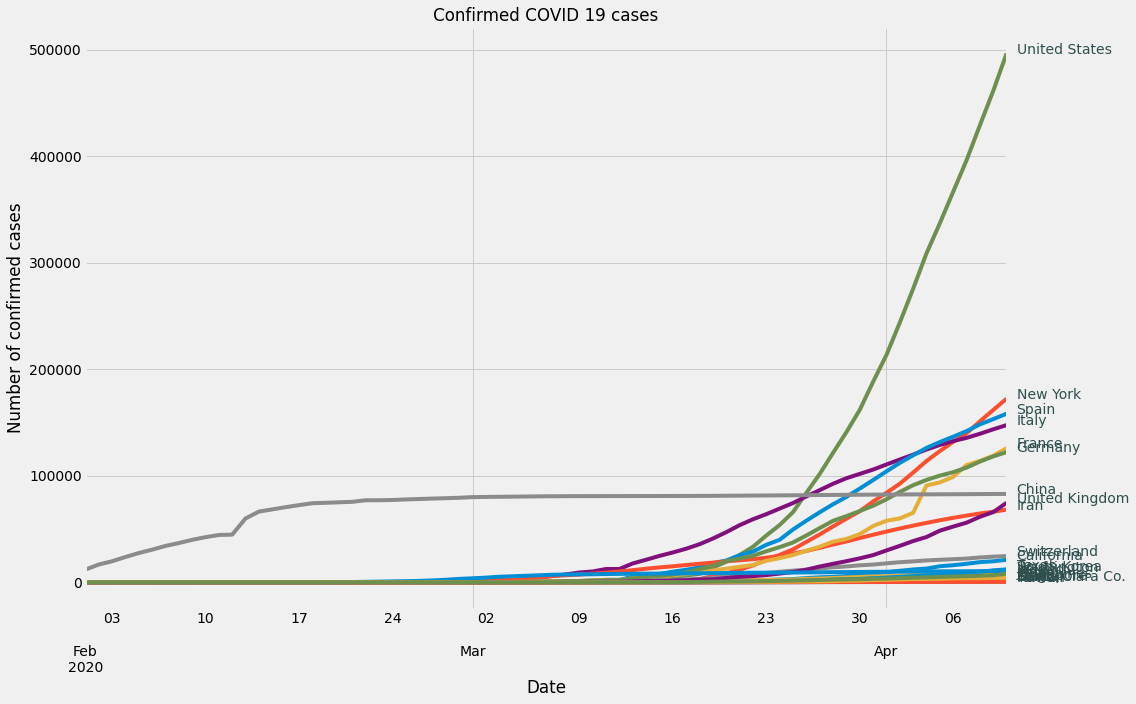

In [24]:
  
graph_data = df.loc['2020-02':,:]
#graph_data = df.drop('China', axis=1).loc['2/21/20':,:]
ax = graph_data.plot(legend=False)
ax.set_title('Confirmed COVID 19 cases', fontsize='large')
ax.set_ylabel('Number of confirmed cases', fontsize='large')
label_lines(graph_data, ax)
plt.tight_layout()
plt.show()
fig = ax.get_figure()
fig.savefig('raw.png')

# Create a 'days since 100 cases' graph

In [25]:
df.tail(2)

,California,New York,Washington,Utah,Hawaii,Idaho,Texas,Santa Clara Co.,Japan,United States,...,Iran,France,Germany,Switzerland,United Kingdom,South Korea,Taiwan,Philippines,Ireland,China
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-09,19710,161779,9639,1747,442,1232,11208,1380,4667,461437,...,66220,118781,118181,24051,65872,10423,380,4076,6574,82883
2020-04-10,21081,172348,10119,1972,442,1354,12105,1442,5530,496535,...,68192,125931,122171,24551,74605,10450,382,4195,8089,82941


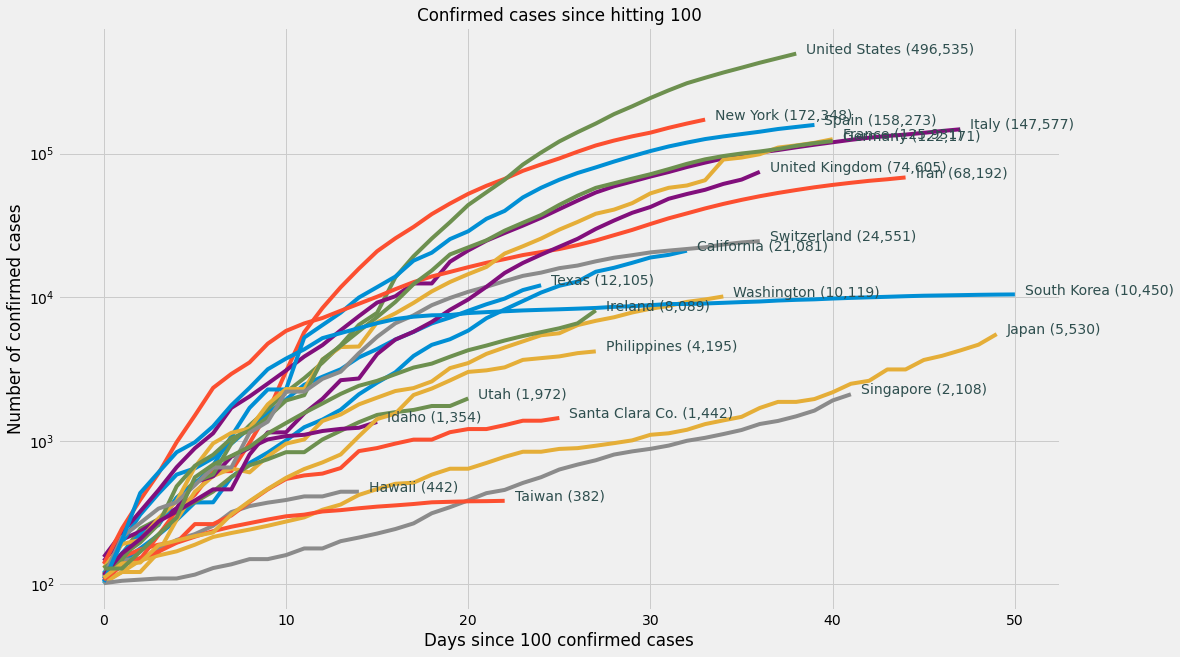

In [26]:
threshold = 100
daysSince100 = pd.DataFrame(index=range(0,len(df.index)))
for location in df.columns:
    # create list of data once above 'threshold'
    tempList = [df.loc[date, location] 
                              for date in df[location].index 
                              if df.loc[date, location] > threshold]
    if (not tempList) or (tempList[-1] <= threshold):
        continue
    # put that list in another list that has NaN's buffered out to length of the DataFrame
    tempListFilled = list()
    for index, _ in enumerate(daysSince100.index):
        if index < len(tempList):
            tempListFilled.append(tempList[index])
        else:
            tempListFilled.append(np.NaN)
    # add the buffered list to the dataframe as a new column
    daysSince100[location] = tempListFilled

daysSince100 = daysSince100.drop('China', axis=1)
daysSince100 = daysSince100.dropna(axis=0, how='all')
ax = daysSince100.plot(logy=True, legend=False)
#ax.set_yscale('log', basey=2)
ax.set_title('Confirmed cases since hitting {}'.format(threshold), fontsize='large')
ax.set_xlabel('Days since {} confirmed cases'.format(threshold), fontsize='large')
ax.set_ylabel('Number of confirmed cases', fontsize='large')
#ax.annotate("Italy on 3/14", xy=(20,21157), xytext=(15, 30000),
#            arrowprops=dict(facecolor='grey', shrink=0.05),)

label_lines(daysSince100, ax, print_value=True)
    
#ax.hlines(60461826, 0, 50, linestyles='dotted', label='Pop of Italy')
plt.show()
fig = ax.get_figure()
fig.savefig('since100.png')

# Cases relative to Population

In [27]:
per = 100000

popdf = pd.DataFrame(index = df.index,
                     data = {
                         'California': 39747267,
                         'New York': 19491339,
                         'Washington': 7797095,
                         'Utah': 3282115,
                         'Hawaii': 1412687,
                         'Idaho': 1826156,
                         'Texas': 29472295,
                         'Santa Clara Co.': 2200000,
                         'Los Angeles Co.': 10500000,
                         'Japan': 126476461,
                         'United States': 331002651,
                         'Singapore': 5850342,
                         'Italy': 60461826,
                         'Spain': 46754778,
                         'Iran': 83992949,
                         'France': 65273511,
                         'Germany': 83783942,
                         'Switzerland': 8654622,
                         'United Kingdom': 67886011,
                         'South Korea': 51269185,
                         'Taiwan': 23816775,
                         'Philippines': 109581078,
                         'Ireland': 4937786,
                         'China': 1439323776,
                         
                     }

)
popdf

casesperdf = df.div(popdf).mul(per)
casesperdf.tail()

,California,China,France,Germany,Hawaii,Idaho,Iran,Ireland,Italy,Japan,...,Singapore,South Korea,Spain,Switzerland,Taiwan,Texas,United Kingdom,United States,Utah,Washington
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-06,40.302142,5.743322,151.612804,123.381638,27.394603,60.290578,72.029856,108.631682,219.224275,2.889075,...,23.502899,20.058833,292.323065,250.236232,1.566123,27.290036,77.009975,110.774641,48.231095,106.590980
2020-04-07,43.653316,5.747004,168.621234,128.500757,29.022706,64.069006,74.516969,115.618619,224.250587,3.088322,...,25.314759,20.150506,303.588224,257.122726,1.578719,30.282677,82.416096,119.703875,49.967780,111.477416
2020-04-08,47.542891,5.753327,174.586901,135.224003,29.022706,66.259400,76.894550,123.010596,230.595087,3.365844,...,27.741968,20.253882,317.015728,268.989218,1.591315,33.173528,90.554739,129.621923,53.227873,118.967385
2020-04-09,49.588315,5.758468,181.974277,141.054476,31.287893,67.464116,78.839951,133.136592,237.548234,3.690015,...,32.647664,20.329951,327.714100,277.897752,1.595514,38.028935,97.033246,139.405832,53.227873,123.622965
2020-04-10,53.037609,5.762498,192.928185,145.816725,31.287893,74.144816,81.187767,163.818359,244.082936,4.372355,...,36.032082,20.382614,338.517274,283.675012,1.603912,41.072472,109.897457,150.009373,60.083209,129.779104


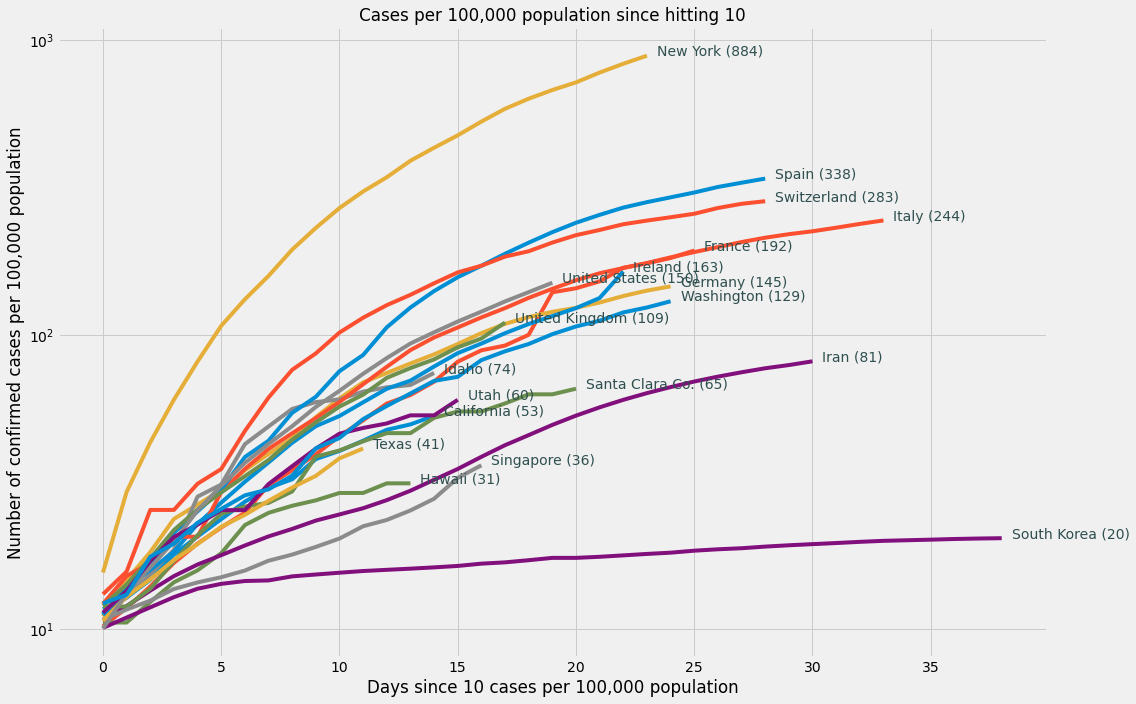

In [28]:
threshold = 10
daysSincerate = pd.DataFrame(index=range(0,len(casesperdf.index)))
for location in casesperdf.columns:
    # create list of data once above 'threshold'
    tempList = [casesperdf.loc[date, location] 
                              for date in casesperdf[location].index 
                              if casesperdf.loc[date, location] > threshold]
    if (not tempList) or (tempList[-1] <= threshold):
        continue
    # put that list in another list that has NaN's buffered out to length of the DataFrame
    tempListFilled = list()
    for index, _ in enumerate(daysSincerate.index):
        if index < len(tempList):
            tempListFilled.append(tempList[index])
        else:
            tempListFilled.append(np.NaN)
    # add the buffered list to the dataframe as a new column
    daysSincerate[location] = tempListFilled


#daysSincerate = daysSincerate.drop(['China','Singapore'], axis=1)
daysSincerate = daysSincerate.dropna(axis=0, how='all')
ax = daysSincerate.plot(logy=True, legend=False)
#ax.set_yscale('log', basey=2)
ax.set_title('Cases per {:,} population since hitting {}'.format(per, threshold), fontsize='large')
ax.set_xlabel('Days since {} cases per {:,} population'.format(threshold, per), fontsize='large')
ax.set_ylabel('Number of confirmed cases per {:,} population'.format(per), fontsize='large')
#ax.annotate("Italy on 3/14", xy=(16,34.99), xytext=(25, 24),
#            arrowprops=dict(facecolor='grey', shrink=0.05),)

label_lines(daysSincerate, ax, print_value=True)

plt.tight_layout()
plt.show()
fig = ax.get_figure()
fig.savefig('pop-adjusted.png')

In [29]:
daysSince100

,California,New York,Washington,Utah,Hawaii,Idaho,Texas,Santa Clara Co.,Japan,United States,...,Spain,Iran,France,Germany,Switzerland,United Kingdom,South Korea,Taiwan,Philippines,Ireland
0,101.0,106.0,102.0,118.0,106.0,146.0,110.0,138.0,105.0,118.0,...,120.0,139.0,130.0,130.0,114.0,116.0,104.0,108.0,111.0,129.0
1,144.0,142.0,122.0,162.0,149.0,205.0,196.0,155.0,122.0,149.0,...,165.0,245.0,191.0,159.0,214.0,164.0,204.0,135.0,140.0,129.0
2,178.0,150.0,122.0,244.0,149.0,234.0,306.0,175.0,147.0,217.0,...,222.0,388.0,204.0,196.0,268.0,207.0,433.0,153.0,142.0,169.0
3,221.0,220.0,167.0,284.0,175.0,281.0,429.0,189.0,159.0,262.0,...,259.0,593.0,288.0,262.0,337.0,274.0,602.0,169.0,187.0,223.0
4,281.0,327.0,282.0,325.0,204.0,340.0,582.0,196.0,170.0,402.0,...,400.0,978.0,380.0,482.0,374.0,322.0,833.0,195.0,202.0,292.0
5,372.0,421.0,442.0,374.0,224.0,515.0,643.0,263.0,189.0,518.0,...,500.0,1501.0,656.0,670.0,491.0,384.0,977.0,215.0,217.0,557.0
6,373.0,613.0,568.0,443.0,256.0,566.0,758.0,263.0,214.0,583.0,...,673.0,2336.0,959.0,799.0,652.0,459.0,1261.0,235.0,230.0,683.0
7,557.0,615.0,642.0,560.0,319.0,776.0,955.0,302.0,228.0,959.0,...,1073.0,2922.0,1136.0,1040.0,652.0,459.0,1766.0,252.0,307.0,785.0
8,700.0,967.0,603.0,675.0,351.0,891.0,1229.0,375.0,241.0,1281.0,...,1695.0,3513.0,1219.0,1176.0,1139.0,802.0,2337.0,267.0,380.0,906.0
9,828.0,1578.0,779.0,744.0,371.0,1022.0,1563.0,459.0,256.0,1663.0,...,2277.0,4747.0,1794.0,1457.0,1359.0,1144.0,3150.0,283.0,462.0,1125.0


# Look at growth factor changes

In [30]:
start_date = '3/22/20'
location = ['California', 'Italy', 'New York']
#location = ['California', 'South Korea', 'Italy', 'Germany', 'New York']
df.loc[start_date:,:]

,California,New York,Washington,Utah,Hawaii,Idaho,Texas,Santa Clara Co.,Japan,United States,...,Iran,France,Germany,Switzerland,United Kingdom,South Korea,Taiwan,Philippines,Ireland,China
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-22,1646,15800,1997,162,53,42,643,263,1101,33276,...,21638,16243,24873,7474,5745,8961,169,380,906,81435
2020-03-23,2108,20884,2221,244,56,68,758,302,1128,43847,...,23049,20123,29056,8795,6726,8961,195,462,1125,81498
2020-03-24,2538,25681,2328,284,90,81,955,375,1193,53740,...,24811,22622,32986,9877,8164,9037,215,552,1329,81591
2020-03-25,2998,30841,2591,325,91,91,1229,459,1307,65778,...,27017,25600,37323,10897,9640,9137,235,636,1564,81661
2020-03-26,3899,37877,3207,374,95,146,1563,542,1387,83836,...,29406,29551,43938,11811,11812,9241,252,707,1819,81782
2020-03-27,4657,44876,3477,443,106,205,1937,574,1468,101657,...,32332,33402,50871,12928,14745,9332,267,803,2121,81897
2020-03-28,5095,52410,4030,560,149,234,2455,591,1693,121465,...,35408,38105,57695,14076,17312,9478,283,1075,2415,81999
2020-03-29,5852,59648,4465,675,149,281,2792,646,1866,140909,...,38309,40708,62095,14829,19780,9583,298,1418,2615,82122
2020-03-30,7138,66663,4923,744,175,340,3147,848,1866,161831,...,41495,45170,66885,15922,22453,9661,306,1546,2910,82198


In [31]:
# calculate growth factor (diff between 2 points divided by the diff between the prior 2 points)
df.loc[start_date:,:].diff().pct_change().add(1)

,California,New York,Washington,Utah,Hawaii,Idaho,Texas,Santa Clara Co.,Japan,United States,...,Iran,France,Germany,Switzerland,United Kingdom,South Korea,Taiwan,Philippines,Ireland,China
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-24,0.930736,0.943548,0.477679,0.487805,11.333333,0.500000,1.713043,1.871795,2.407407,0.935862,...,1.248760,0.644072,0.939517,0.819076,1.465851,inf,0.769231,1.097561,0.931507,1.476190
2020-03-25,1.069767,1.075672,2.457944,1.025000,0.029412,0.769231,1.390863,1.150685,1.753846,1.216820,...,1.251986,1.191677,1.103562,0.942699,1.026426,1.315789,1.000000,0.933333,1.151961,0.752688
2020-03-26,1.958696,1.363566,2.342205,1.195122,4.000000,5.500000,1.218978,0.988095,0.701754,1.500083,...,1.082956,1.326729,1.525248,0.896078,1.471545,1.040000,0.850000,0.845238,1.085106,1.728571
2020-03-27,0.841287,0.994741,0.438312,1.408163,2.750000,1.072727,1.119760,0.385542,1.012500,0.986876,...,1.224780,0.974690,1.048073,1.222101,1.350368,0.875000,0.882353,1.352113,1.184314,0.950413
2020-03-28,0.577836,1.076439,2.048148,1.695652,3.909091,0.491525,1.385027,0.531250,2.777778,1.111498,...,1.051265,1.221241,0.984278,1.027753,0.875213,1.604396,1.066667,2.833333,0.973510,0.886957
2020-03-29,1.728311,0.960711,0.786618,0.982906,0.000000,1.620690,0.650579,3.235294,0.768889,0.981624,...,0.943108,0.553477,0.644783,0.655923,0.961434,0.719178,0.937500,1.261029,0.680272,1.205882
2020-03-30,1.698811,0.969190,1.052874,0.600000,inf,1.255319,1.053412,3.672727,0.000000,1.076013,...,1.098242,1.714176,1.088636,1.451527,1.083063,0.742857,0.533333,0.373178,1.475000,0.617886


In [32]:
# Many countries didn't update their reports on 3/12 leading to 'inf' growth
# factor on 3/13.  I'm going to drop 3/12 data to get a better trend
#tempdf = df.drop('3/12/20', axis='index')
tempdf = df
tempdf.loc[start_date:,:].diff().pct_change().add(1)

,California,New York,Washington,Utah,Hawaii,Idaho,Texas,Santa Clara Co.,Japan,United States,...,Iran,France,Germany,Switzerland,United Kingdom,South Korea,Taiwan,Philippines,Ireland,China
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-24,0.930736,0.943548,0.477679,0.487805,11.333333,0.500000,1.713043,1.871795,2.407407,0.935862,...,1.248760,0.644072,0.939517,0.819076,1.465851,inf,0.769231,1.097561,0.931507,1.476190
2020-03-25,1.069767,1.075672,2.457944,1.025000,0.029412,0.769231,1.390863,1.150685,1.753846,1.216820,...,1.251986,1.191677,1.103562,0.942699,1.026426,1.315789,1.000000,0.933333,1.151961,0.752688
2020-03-26,1.958696,1.363566,2.342205,1.195122,4.000000,5.500000,1.218978,0.988095,0.701754,1.500083,...,1.082956,1.326729,1.525248,0.896078,1.471545,1.040000,0.850000,0.845238,1.085106,1.728571
2020-03-27,0.841287,0.994741,0.438312,1.408163,2.750000,1.072727,1.119760,0.385542,1.012500,0.986876,...,1.224780,0.974690,1.048073,1.222101,1.350368,0.875000,0.882353,1.352113,1.184314,0.950413
2020-03-28,0.577836,1.076439,2.048148,1.695652,3.909091,0.491525,1.385027,0.531250,2.777778,1.111498,...,1.051265,1.221241,0.984278,1.027753,0.875213,1.604396,1.066667,2.833333,0.973510,0.886957
2020-03-29,1.728311,0.960711,0.786618,0.982906,0.000000,1.620690,0.650579,3.235294,0.768889,0.981624,...,0.943108,0.553477,0.644783,0.655923,0.961434,0.719178,0.937500,1.261029,0.680272,1.205882
2020-03-30,1.698811,0.969190,1.052874,0.600000,inf,1.255319,1.053412,3.672727,0.000000,1.076013,...,1.098242,1.714176,1.088636,1.451527,1.083063,0.742857,0.533333,0.373178,1.475000,0.617886


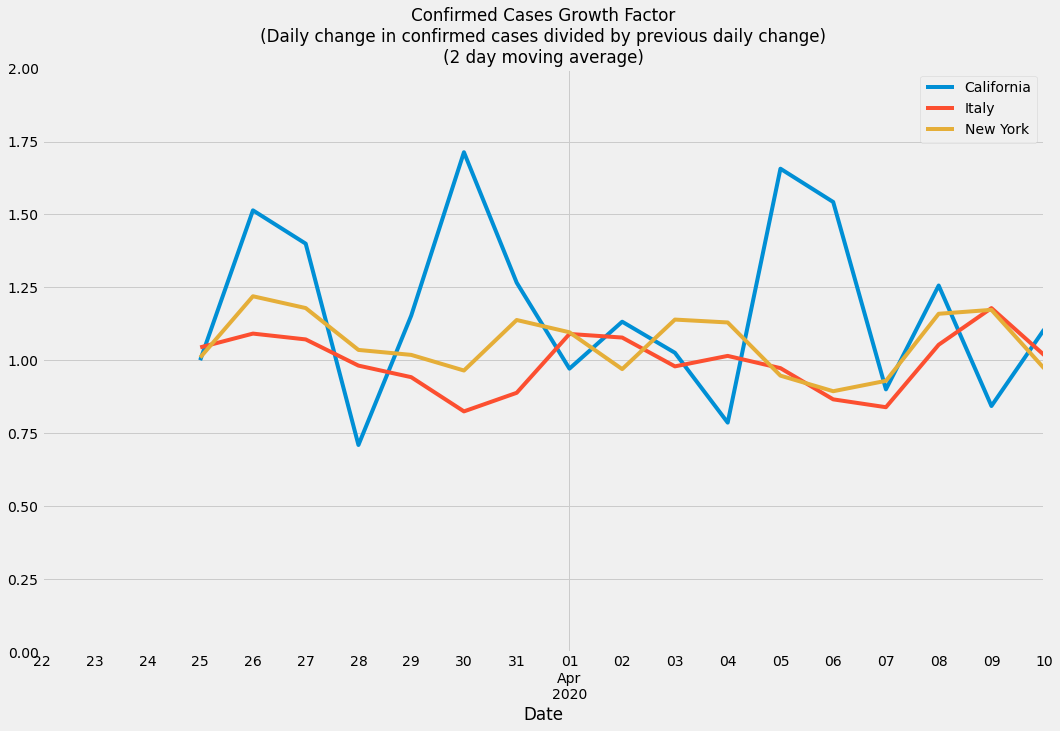

In [33]:
# graph the growth factors
window = 2
ax = tempdf.loc[start_date:,location].diff().pct_change().add(1).rolling(window).mean().plot()
ax.set_ylim(ymin=0, ymax=2)
ax.set_title("Confirmed Cases Growth Factor\n(Daily change in confirmed cases divided by previous daily change)\n({} day moving average)".format(window), fontsize='large')
fig = ax.get_figure()
fig.savefig('growth_factors.png')